# Tyrosinase inhibitors

### Librairies

In [1]:
!pip install pandas rdkit tqdm useful_rdkit_utils seaborn scikit-posthocs chembl_downloader chembl_webresource_client pubchempy matplotlib seaborn scikit-learn


In [3]:
#Machine Learning Librairies

!pip install mglearn

In [4]:
!pip install imbalanced-learn

### Librairies import

In [5]:
# RDKIT:
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, rdMolDescriptors, PandasTools
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import SaltRemover
from rdkit.Chem import inchi

# Datos
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, is_valid_linkage, cut_tree

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

# Machine Learning
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
import mglearn

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
# Chembl
from chembl_webresource_client.new_client import new_client

# Importar libreria para ver una barra con el progreso de cada comando
from tqdm.auto import tqdm
tqdm.pandas()

Database download

In [6]:
target_id = "CHEMBL1973"

#Target Activity
activity = new_client.activity
bioactivities = activity.filter(target_chembl_id=target_id).filter(standard_type="IC50")

# DataFrame Transform
bioactivities_df = pd.DataFrame.from_dict(bioactivities)

# Valid IC50 filtering
bioactivities_df = bioactivities_df[bioactivities_df['standard_value'].notna()]
bioactivities_df = bioactivities_df[bioactivities_df['standard_units'] == 'nM']

bioactivities_df


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,35518,[],CHEMBL814341,Inhibitory activity against mushroom tyrosinase,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,0.78
1,None,None,40253,[],CHEMBL814341,Inhibitory activity against mushroom tyrosinase,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,0.39
2,None,None,43855,[],CHEMBL814341,Inhibitory activity against mushroom tyrosinase,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,0.33
3,None,None,52737,[],CHEMBL814341,Inhibitory activity against mushroom tyrosinase,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,4.48
4,None,None,64278,[],CHEMBL814341,Inhibitory activity against mushroom tyrosinase,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,2.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25588947,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5355298,Inhibition of tyrosinase in human MNT-1 cell l...,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,15.0
358,None,None,25588948,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5355298,Inhibition of tyrosinase in human MNT-1 cell l...,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,100.0
359,None,None,25588970,[],CHEMBL5355310,Inhibition of human tyrosinase,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,3000.0
360,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25588971,[],CHEMBL5355311,Inhibition of truncated His-tagged human tyros...,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,21.0


In [7]:
bioactivities_df['target_pref_name'].value_counts()

,count
target_pref_name,
Tyrosinase,340


In [8]:
bioactivities_df['type'].value_counts()

,count
type,
IC50,340


### Curado de sales

In [9]:
remover= SaltRemover.SaltRemover()
bioactivities_df['canonical_smiles'] = bioactivities_df['canonical_smiles'].progress_apply(lambda x: remover.StripMol(Chem.MolFromSmiles(x), dontRemoveEverything=True))

  0%|          | 0/340 [00:00<?, ?it/s]

In [10]:
# Drop Duplicates
bioactivities_df = bioactivities_df.drop_duplicates(subset='molecule_chembl_id')
bioactivities_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,35518,[],CHEMBL814341,Inhibitory activity against mushroom tyrosinase,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,0.78
1,None,None,40253,[],CHEMBL814341,Inhibitory activity against mushroom tyrosinase,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,0.39
2,None,None,43855,[],CHEMBL814341,Inhibitory activity against mushroom tyrosinase,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,0.33
3,None,None,52737,[],CHEMBL814341,Inhibitory activity against mushroom tyrosinase,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,4.48
4,None,None,64278,[],CHEMBL814341,Inhibitory activity against mushroom tyrosinase,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,2.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,None,None,25588944,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5355298,Inhibition of tyrosinase in human MNT-1 cell l...,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,100.0
355,None,None,25588945,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5355298,Inhibition of tyrosinase in human MNT-1 cell l...,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,100.0
356,None,None,25588946,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5355298,Inhibition of tyrosinase in human MNT-1 cell l...,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,100.0
357,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25588947,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5355298,Inhibition of tyrosinase in human MNT-1 cell l...,B,None,None,BAO_0000190,...,Homo sapiens,Tyrosinase,9606,None,None,IC50,uM,UO_0000065,None,15.0


In [11]:
#@ Getting smiles

bioactivities_df['smiles'] = bioactivities_df['molecule_chembl_id'].progress_apply(
    lambda chembl_id: new_client.molecule.get(chembl_id).get('molecule_structures', {}).get('canonical_smiles')
)


  0%|          | 0/263 [00:00<?, ?it/s]

/tmp/ipython-input-11-1213098894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bioactivities_df['smiles'] = bioactivities_df['molecule_chembl_id'].progress_apply(


In [12]:
# Clean List
SMILES = []
IC50 = []
ID = []

for i in range(len(bioactivities_df)):
    smiles = bioactivities_df['smiles'].iloc[i]
    mol_id = bioactivities_df['molecule_chembl_id'].iloc[i]
    ic50 = bioactivities_df['standard_value'].iloc[i]
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        SMILES.append(Chem.MolToSmiles(mol))  # canonical smiles
        IC50.append(float(ic50))
        ID.append(mol_id)
    else:
        print(f'Invalid SMILES: {smiles} at row {i}')
print('Loop Ended')


Loop Ended


,ID,SMILES,IC50,ROMol
0,CHEMBL430491,O=C(N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1...,780.0,
1,CHEMBL98924,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccc(O)cc...,390.0,
2,CHEMBL98925,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C...,330.0,
3,CHEMBL321140,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1c[nH]c2c...,4480.0,
4,CHEMBL432017,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)...,2180.0,
...,...,...,...,...
258,CHEMBL5426749,Oc1ccc(Cc2cc3cccc(O)c3o2)c(O)c1,100000.0,
259,CHEMBL5423130,Cc1c(C(=O)c2ccc(O)cc2O)oc2c(O)cccc12,100000.0,
260,CHEMBL5397672,Nc1c(C(=O)c2ccc(O)cc2O)oc2c(O)cccc12,100000.0,
261,CHEMBL5396899,O=C1/C(=C/c2c(O)cc(O)cc2O)Oc2cc(O)ccc21,15000.0,

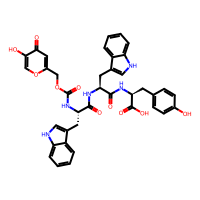
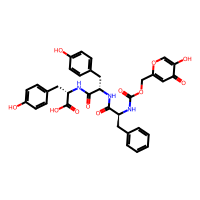
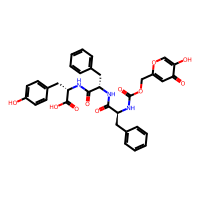
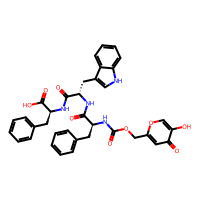
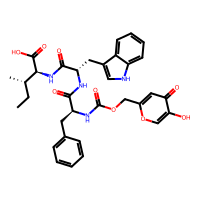
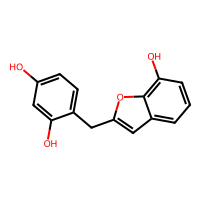
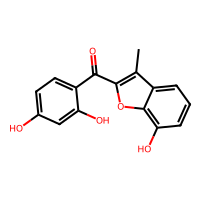
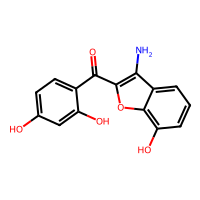
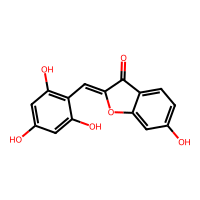
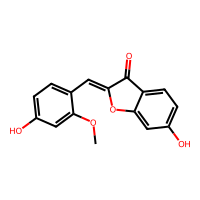

In [13]:
df_clean = pd.DataFrame({
    'ID': ID,
    'SMILES': SMILES,
    'IC50': IC50,
})

PandasTools.AddMoleculeColumnToFrame(df_clean, smilesCol='SMILES')

df_clean


In [14]:
#@ Activity Clasification
Activity = []

for i in IC50:
  if i < 1000:
    Activity.append('Active')
  else:
    Activity.append('Inactive')

df_clean['Activity'] = Activity

df_clean.head()


,ID,SMILES,IC50,ROMol,Activity
0,CHEMBL430491,O=C(N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1...,780.0,<rdkit.Chem.rdchem.Mol object at 0x7e73e34d49e0>,Active
1,CHEMBL98924,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccc(O)cc...,390.0,<rdkit.Chem.rdchem.Mol object at 0x7e73e34d4890>,Active
2,CHEMBL98925,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C...,330.0,<rdkit.Chem.rdchem.Mol object at 0x7e73e34d4970>,Active
3,CHEMBL321140,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1c[nH]c2c...,4480.0,<rdkit.Chem.rdchem.Mol object at 0x7e73e34d4a50>,Inactive
4,CHEMBL432017,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)...,2180.0,<rdkit.Chem.rdchem.Mol object at 0x7e73e34d4ac0>,Inactive


In [15]:
df_clean['Activity'].value_counts()

,count
Activity,
Inactive,242
Active,21


In [16]:
#@ Descriptors

num_atoms = []
mol_weight = []
rings = []
fpdm1 = []
rot_bonds = []
tpsa = []
logp = []
num_h_acceptors = []
num_h_donors = []
heavy_atom_count = []

for index, row in df_clean.iterrows():
    mol = row['ROMol']
    if mol:
        num_atoms.append(len(mol.GetAtoms()))
        mol_weight.append(Descriptors.MolWt(mol))
        rings.append(Descriptors.RingCount(mol))
        fpdm1.append(Descriptors.FpDensityMorgan1(mol))
        rot_bonds.append(Descriptors.NumRotatableBonds(mol))
        tpsa.append(Descriptors.TPSA(mol))
        logp.append(Descriptors.MolLogP(mol))
        num_h_acceptors.append(Descriptors.NumHAcceptors(mol))
        num_h_donors.append(Descriptors.NumHDonors(mol))
        heavy_atom_count.append(Descriptors.HeavyAtomCount(mol))
    else:
        num_atoms.append(None)
        mol_weight.append(None)
        rings.append(None)
        fpdm1.append(None)
        rot_bonds.append(None)
        tpsa.append(None)
        logp.append(None)
        num_h_acceptors.append(None)
        num_h_donors.append(None)
        heavy_atom_count.append(None)


df_clean['NumAtoms'] = num_atoms
df_clean['MolWeight'] = mol_weight
df_clean['Rings'] = rings
df_clean['FpDM1'] = fpdm1
df_clean['RotBonds'] = rot_bonds
df_clean['TPSA'] = tpsa
df_clean['LogP'] = logp
df_clean['NumHAcceptors'] = num_h_acceptors
df_clean['NumHDonors'] = num_h_donors
df_clean['HeavyAtomCount'] = heavy_atom_count


df_clean.head()


,ID,SMILES,IC50,ROMol,Activity,NumAtoms,MolWeight,Rings,FpDM1,RotBonds,TPSA,LogP,NumHAcceptors,NumHDonors,HeavyAtomCount
0,CHEMBL430491,O=C(N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1...,780.0,<rdkit.Chem.rdchem.Mol object at 0x7e73e34d49e0>,Active,53,721.723,6,0.716981,14,236.08,3.3907,9,8,53
1,CHEMBL98924,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccc(O)cc...,390.0,<rdkit.Chem.rdchem.Mol object at 0x7e73e34d4890>,Active,48,659.648,4,0.666667,14,224.73,2.1337,10,7,48
2,CHEMBL98925,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C...,330.0,<rdkit.Chem.rdchem.Mol object at 0x7e73e34d4970>,Active,47,643.649,4,0.680851,14,204.50,2.4281,9,6,47
3,CHEMBL321140,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1c[nH]c2c...,4480.0,<rdkit.Chem.rdchem.Mol object at 0x7e73e34d4a50>,Inactive,49,666.687,5,0.755102,14,200.06,3.2038,8,6,49
4,CHEMBL432017,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)...,2180.0,<rdkit.Chem.rdchem.Mol object at 0x7e73e34d4ac0>,Inactive,46,632.670,4,0.934783,14,200.06,3.0072,8,6,46


### Fingerprints Clustering

In [17]:

fps = [FingerprintMols.FingerprintMol(mol) for mol in df_clean['ROMol']]

In [18]:
vector = np.array(fps[0])
print(vector)

[1 1 0 ... 0 1 1]


0.7878513145965549


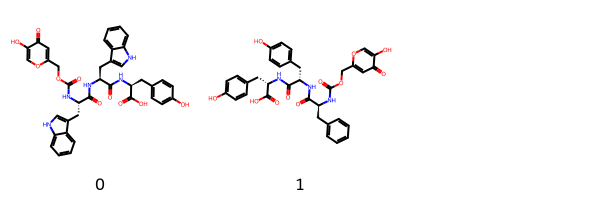

In [19]:
# Proving random molecules similitary

print(DataStructs.FingerprintSimilarity(fps[0], fps[1]))


Draw.MolsToGridImage([df_clean['ROMol'][0], df_clean['ROMol'][1]], legends=['0', '1'])

In [20]:

import warnings
warnings.filterwarnings('ignore')


size = len(df_clean)

hmap = np.empty(shape=(size, size))

table = pd.DataFrame()

for i in range(len(df_clean)):
    for j in range(len(df_clean)):
        similarity = DataStructs.FingerprintSimilarity(fps[i], fps[j])
        hmap[i, j] = similarity
        table.loc[df_clean['ID'][i], df_clean['ID'][j]] = similarity

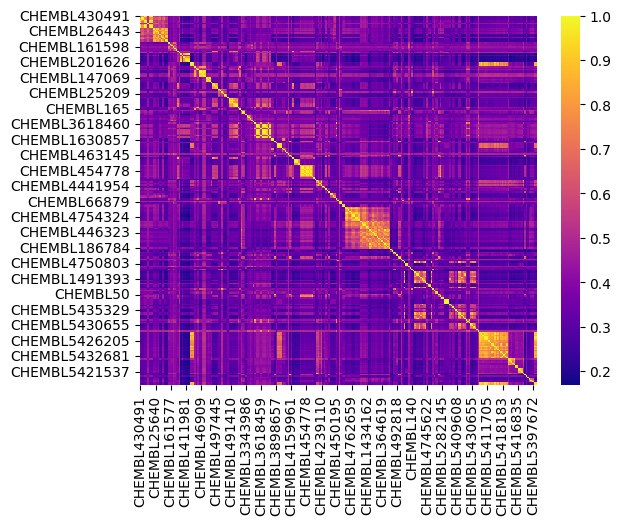

In [21]:
heatmap = sns.heatmap(data=table,cmap='plasma')
plt.show()

In [22]:
#@ Dendogram
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [23]:
linked = linkage(hmap, 'complete')
print(is_valid_linkage(linked))
labelList = [df_clean['ID'][i] for i in range(len(df_clean))]

True


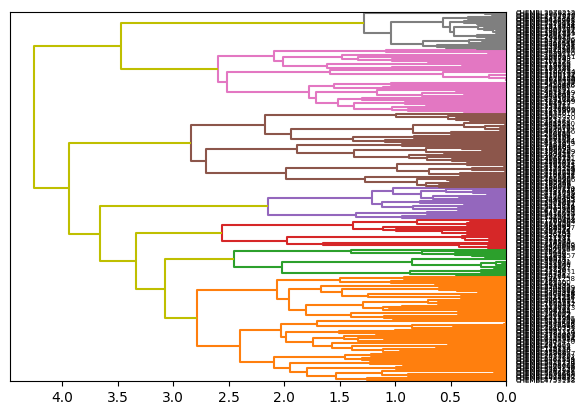

In [24]:
o = dendrogram(linked, orientation='left', labels=labelList, distance_sort='descending', show_leaf_counts=True,  above_threshold_color='y')

,ID,SMILES,IC50,ROMol,Activity,NumAtoms,MolWeight,Rings,FpDM1,RotBonds,TPSA,LogP,NumHAcceptors,NumHDonors,HeavyAtomCount,Cluster_fingerprints
0,CHEMBL430491,O=C(N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1...,780.0,,Active,53,721.723,6,0.716981,14,236.08,3.39070,9,8,53,0
1,CHEMBL98924,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccc(O)cc...,390.0,,Active,48,659.648,4,0.666667,14,224.73,2.13370,10,7,48,0
2,CHEMBL98925,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C...,330.0,,Active,47,643.649,4,0.680851,14,204.50,2.42810,9,6,47,0
3,CHEMBL321140,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1c[nH]c2c...,4480.0,,Inactive,49,666.687,5,0.755102,14,200.06,3.20380,8,6,49,0
4,CHEMBL432017,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)...,2180.0,,Inactive,46,632.670,4,0.934783,14,200.06,3.00720,8,6,46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,CHEMBL5426749,Oc1ccc(Cc2cc3cccc(O)c3o2)c(O)c1,100000.0,,Inactive,19,256.257,3,0.894737,2,73.83,3.14040,4,3,19,3
259,CHEMBL5423130,Cc1c(C(=O)c2ccc(O)cc2O)oc2c(O)cccc12,100000.0,,Inactive,21,284.267,3,1.047619,2,90.90,3.08902,5,3,21,3
260,CHEMBL5397672,Nc1c(C(=O)c2ccc(O)cc2O)oc2c(O)cccc12,100000.0,,Inactive,21,285.255,3,1.047619,2,116.92,2.36280,6,4,21,3
261,CHEMBL5396899,O=C1/C(=C/c2c(O)cc(O)cc2O)Oc2cc(O)ccc21,15000.0,,Inactive,21,286.239,3,0.904762,1,107.22,2.12520,6,4,21,4

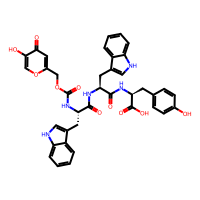
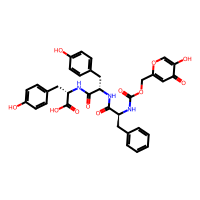
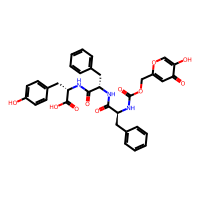
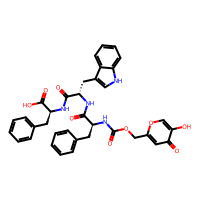
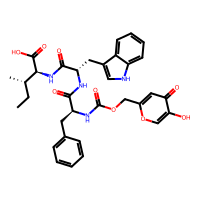
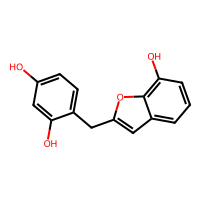
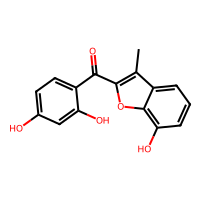
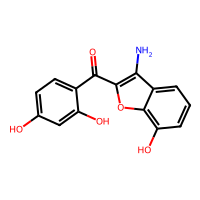
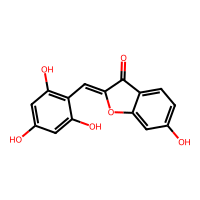
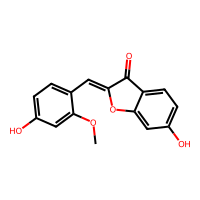

In [25]:
n = 7
clusters = cut_tree(linked, 7)
df_clean['Cluster_fingerprints'] = clusters.flatten()
df_clean

In [26]:
df_clean['Cluster_fingerprints'].value_counts()

,count
Cluster_fingerprints,
3,75
5,53
1,45
4,27
2,22
6,22
0,19


In [27]:
new_data = list(reversed(o['ivl']))
hmap_2 = np.empty(shape=(size, size))
for index, i in enumerate(new_data):
    for jndex, j in enumerate(new_data):
        hmap_2[index, jndex] = table.loc[i].at[j]

[]

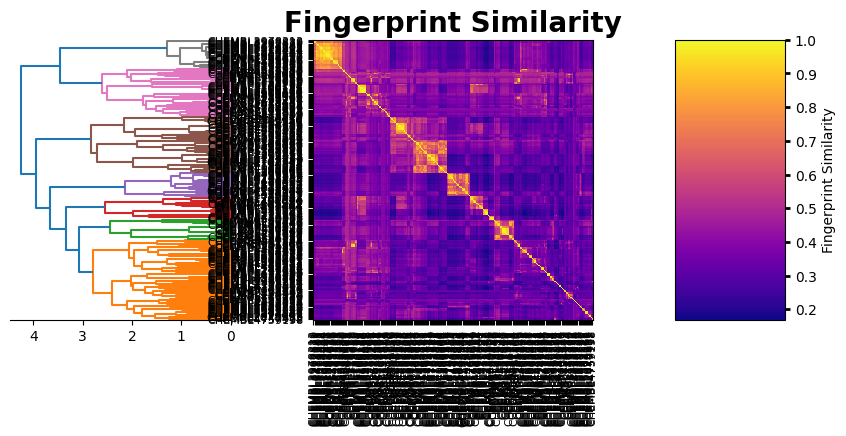

In [28]:
figure = plt.figure(figsize=(10,8))

gs1 = gridspec.GridSpec(2, 7)
gs1.update(wspace=0.01)

ax1 = plt.subplot(gs1[0:-1, :2])
dendrogram(linked, orientation='left', distance_sort='descending', show_leaf_counts=True, no_labels=True)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = plt.subplot(gs1[0:-1, 2:6])
f = ax2.imshow(hmap_2, cmap='plasma', interpolation='nearest')
ax2.set_title('Fingerprint Similarity', fontsize=20, weight='bold')
ax2.set_xticks(range(len(new_data)))
ax2.set_yticks(range(len(new_data)))
ax2.set_xticklabels(new_data, rotation=90, size=8)
ax2.set_yticklabels(new_data, size=8)


ax3 = plt.subplot(gs1[0:-1, 6:7])
m = plt.colorbar(f, cax=ax3, shrink=0.75, orientation='vertical', spacing='uniform', pad=0.01)
m.set_label('Fingerprint Similarity')


plt.tick_params('both', width=2)


plt.plot()

Cluster Analysis

In [29]:
df_clean_cluster_1 = df_clean.loc[df_clean['Cluster_fingerprints'] == 0]
df_clean_cluster_2 = df_clean.loc[df_clean['Cluster_fingerprints'] == 1]
df_clean_cluster_3 = df_clean.loc[df_clean['Cluster_fingerprints'] == 2]
df_clean_cluster_4 = df_clean.loc[df_clean['Cluster_fingerprints'] == 3]
df_clean_cluster_5 = df_clean.loc[df_clean['Cluster_fingerprints'] == 4]
df_clean_cluster_6 = df_clean.loc[df_clean['Cluster_fingerprints'] == 5]
df_clean_cluster_7 = df_clean.loc[df_clean['Cluster_fingerprints'] == 6]

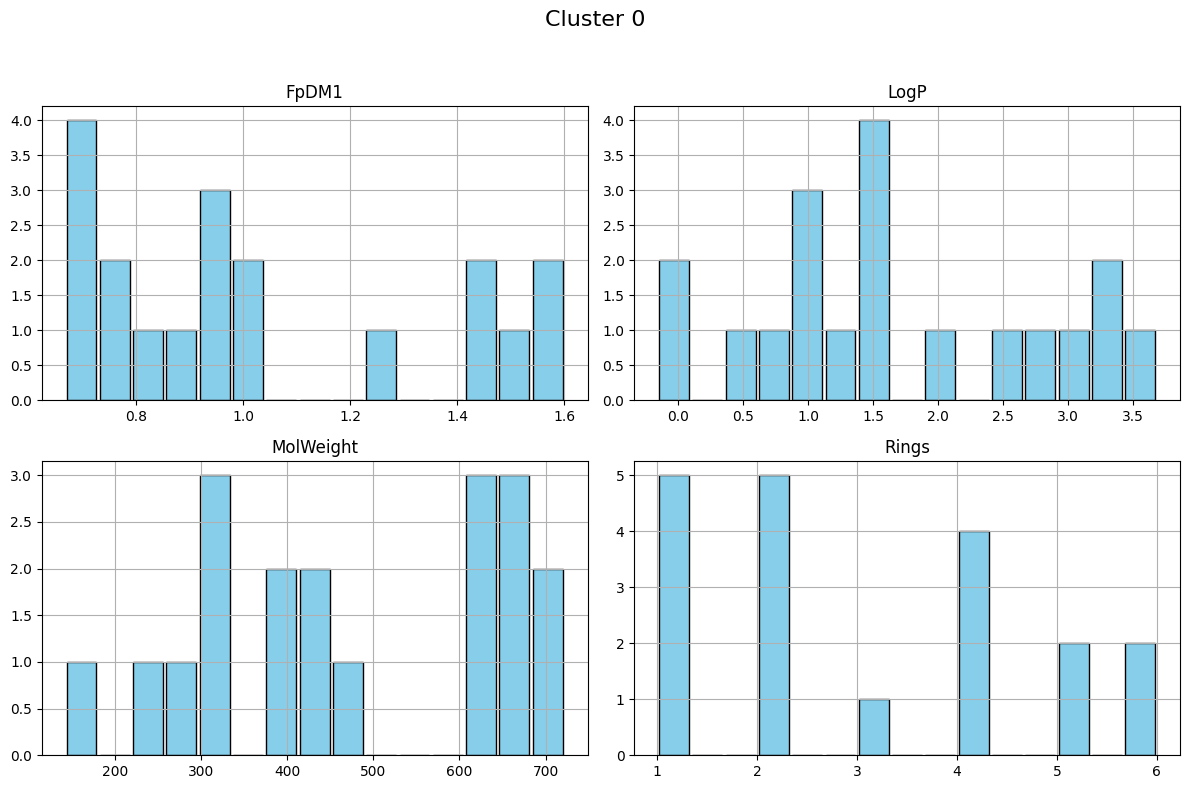

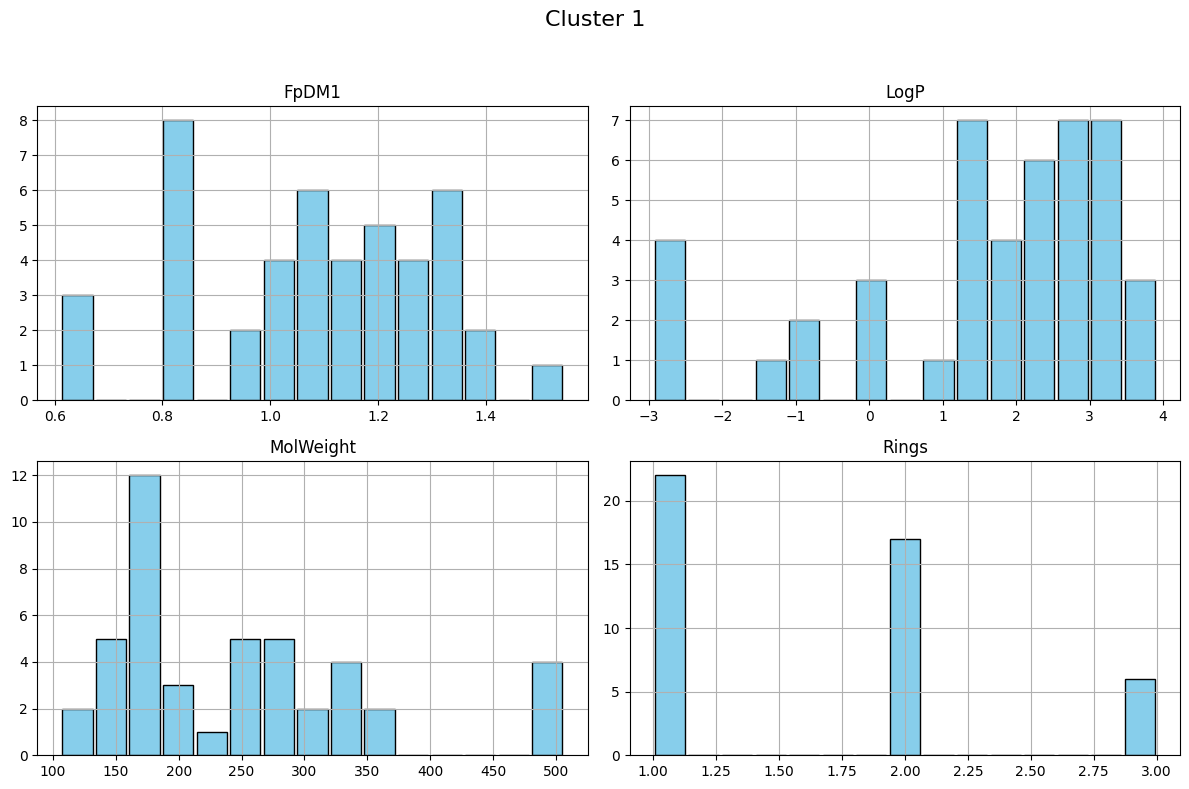

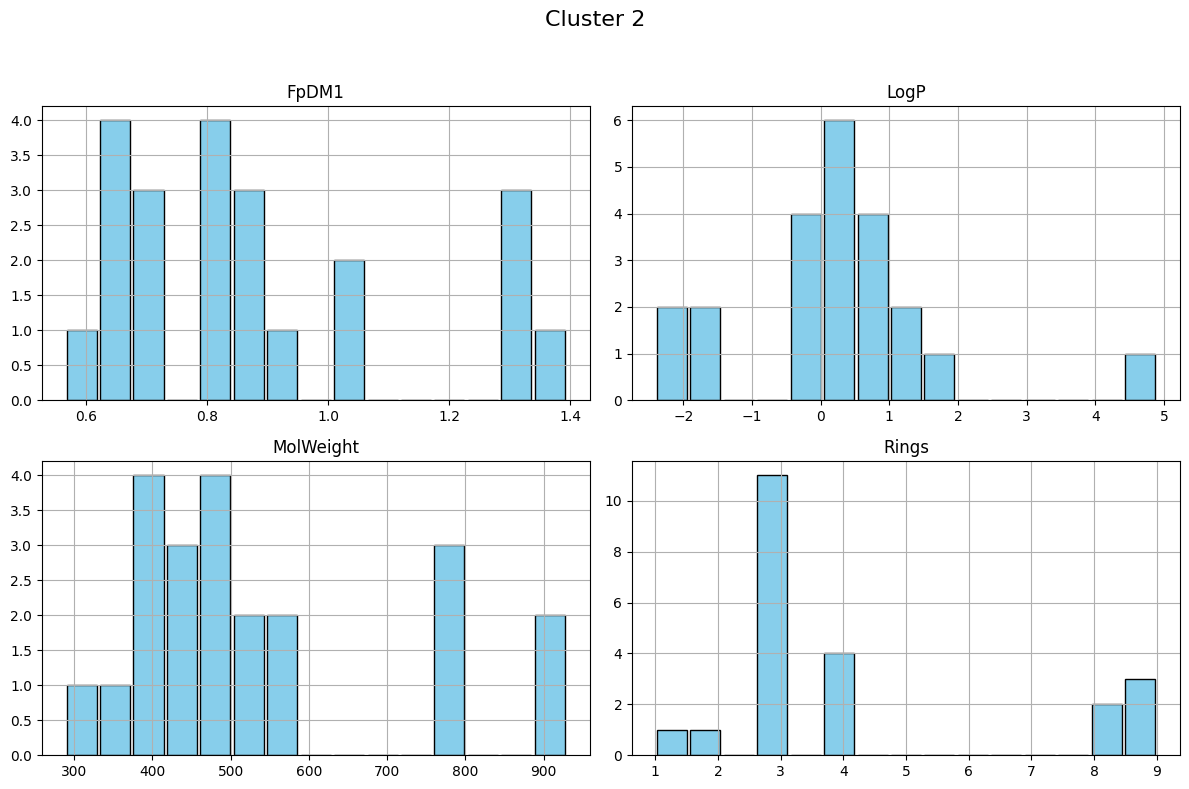

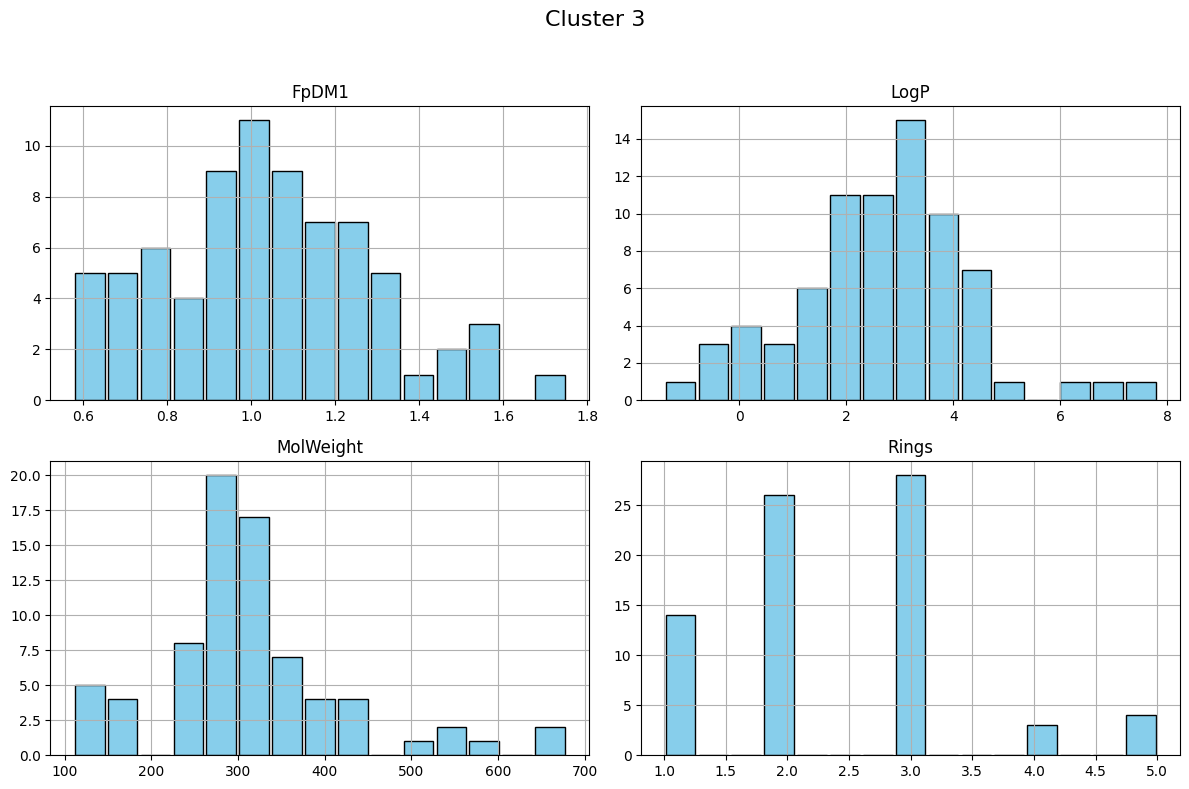

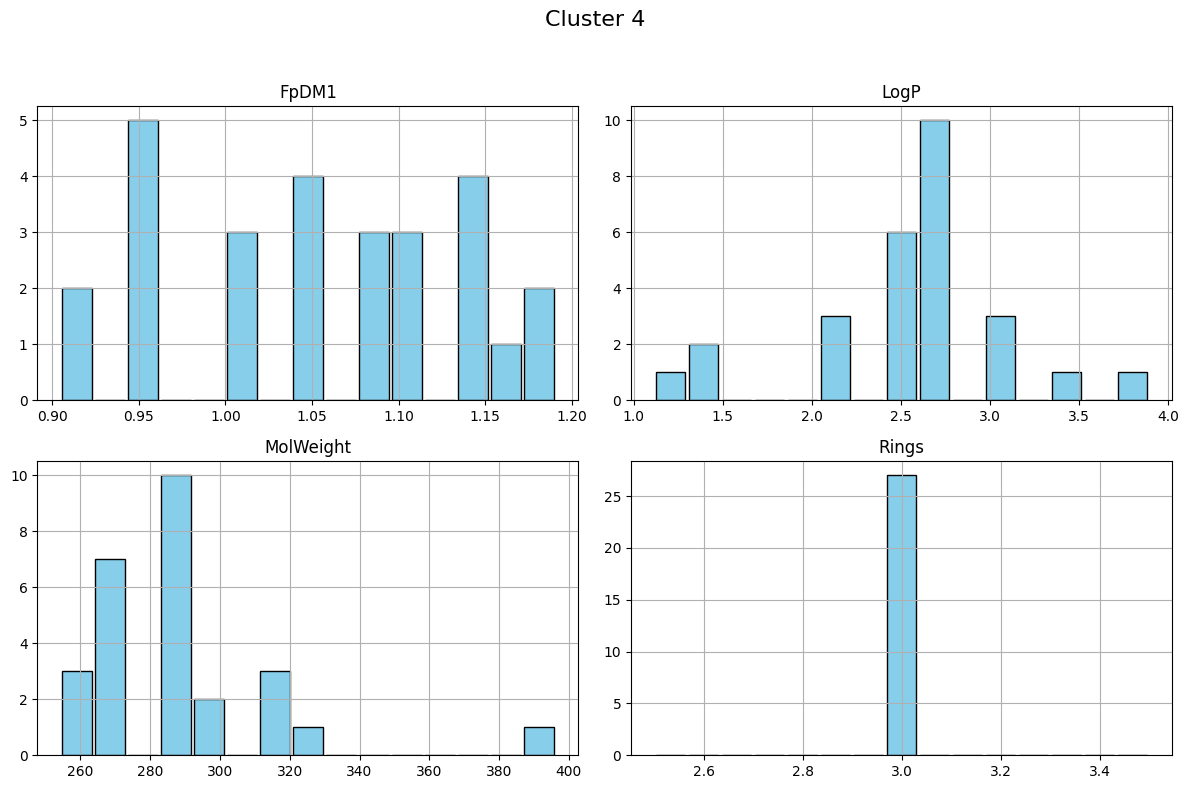

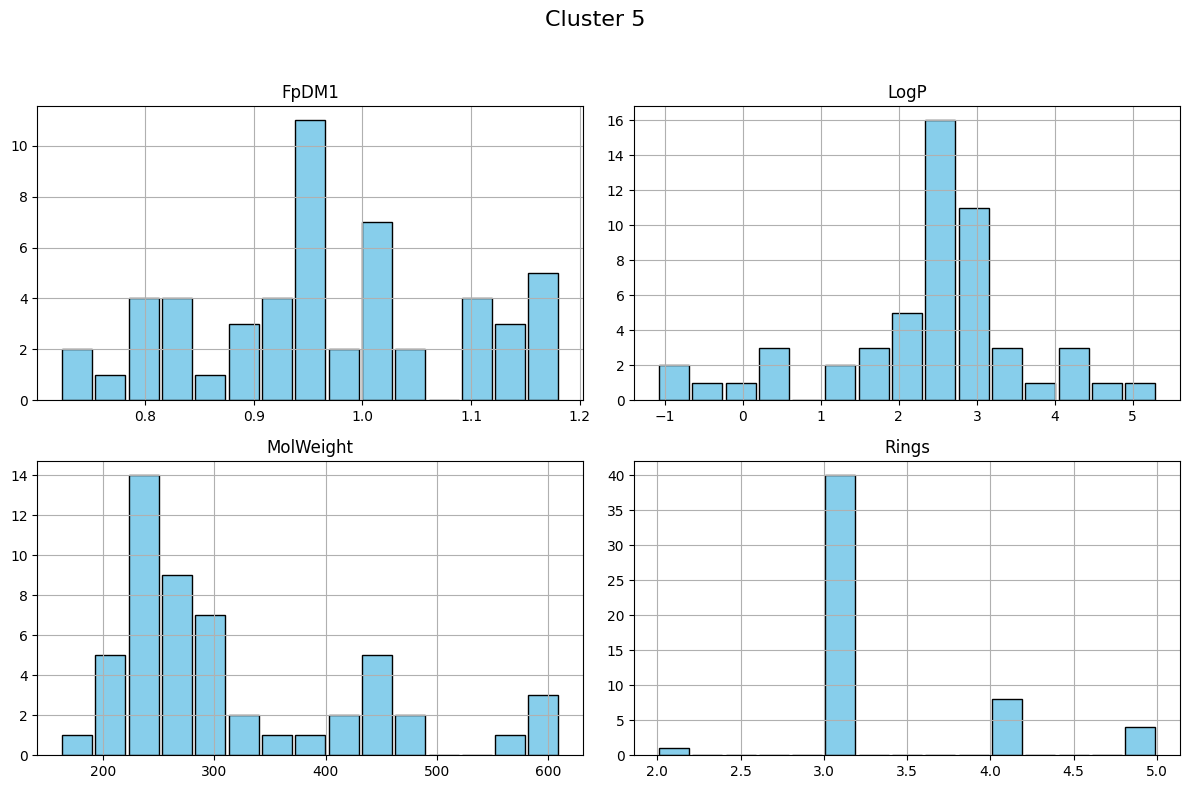

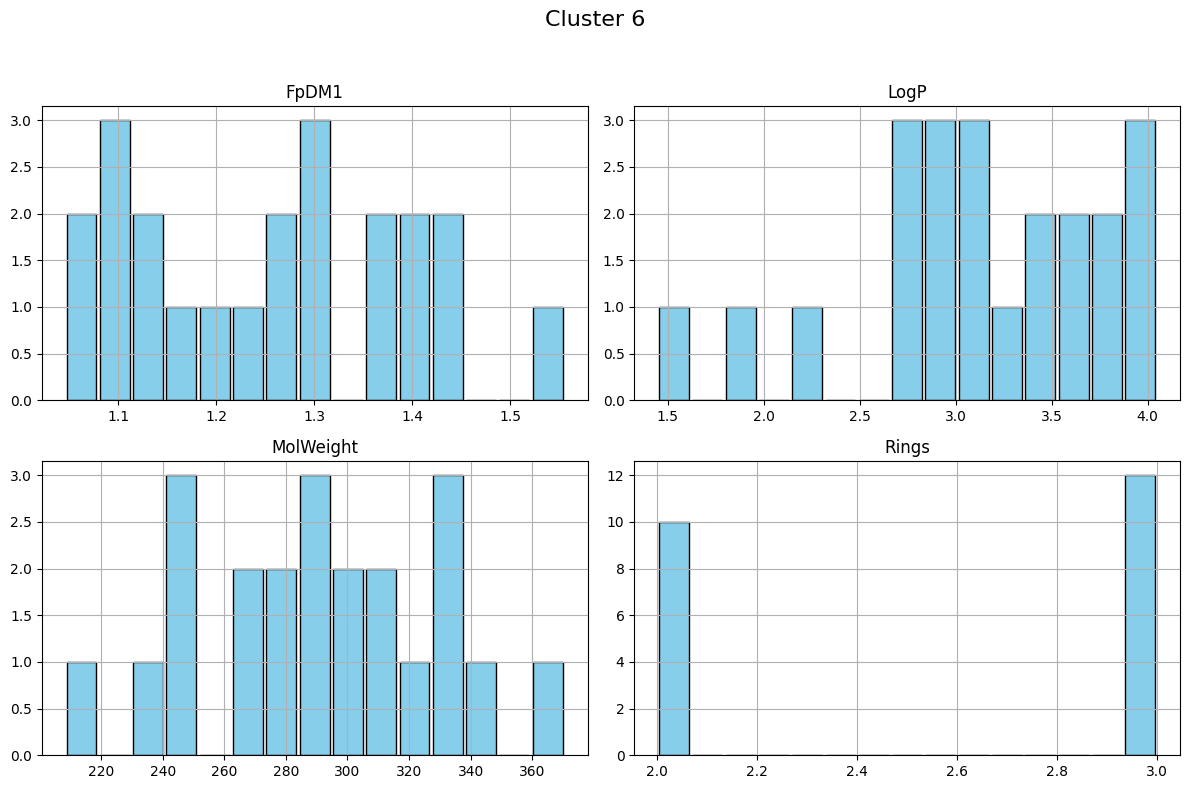

In [30]:

propiedades = ['FpDM1', 'LogP', 'MolWeight', 'Rings']

for cluster_id in sorted(df_clean['Cluster_fingerprints'].unique()):

    datos_cluster = df_clean[df_clean['Cluster_fingerprints'] == cluster_id]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'Cluster {cluster_id}', fontsize=16)

    for ax, prop in zip(axes.flat, propiedades):
        ax.hist(datos_cluster[prop].dropna(), bins=15, rwidth=0.9, color='skyblue', edgecolor='black')
        ax.set_title(prop)
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Fenol Gruop

,ID,SMILES,IC50,ROMol,Activity,NumAtoms,MolWeight,Rings,FpDM1,RotBonds,TPSA,LogP,NumHAcceptors,NumHDonors,HeavyAtomCount,Cluster_fingerprints,Grupo_Fenol,Fenol_bit
0,CHEMBL430491,O=C(N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1...,780.0,,1,53,721.723,6,0.716981,14,236.08,3.39070,9,8,53,0,True,1
1,CHEMBL98924,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccc(O)cc...,390.0,,1,48,659.648,4,0.666667,14,224.73,2.13370,10,7,48,0,True,1
2,CHEMBL98925,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C...,330.0,,1,47,643.649,4,0.680851,14,204.50,2.42810,9,6,47,0,True,1
3,CHEMBL321140,O=C(N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1c[nH]c2c...,4480.0,,0,49,666.687,5,0.755102,14,200.06,3.20380,8,6,49,0,False,0
4,CHEMBL432017,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)...,2180.0,,0,46,632.670,4,0.934783,14,200.06,3.00720,8,6,46,0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,CHEMBL5426749,Oc1ccc(Cc2cc3cccc(O)c3o2)c(O)c1,100000.0,,0,19,256.257,3,0.894737,2,73.83,3.14040,4,3,19,3,True,1
259,CHEMBL5423130,Cc1c(C(=O)c2ccc(O)cc2O)oc2c(O)cccc12,100000.0,,0,21,284.267,3,1.047619,2,90.90,3.08902,5,3,21,3,True,1
260,CHEMBL5397672,Nc1c(C(=O)c2ccc(O)cc2O)oc2c(O)cccc12,100000.0,,0,21,285.255,3,1.047619,2,116.92,2.36280,6,4,21,3,True,1
261,CHEMBL5396899,O=C1/C(=C/c2c(O)cc(O)cc2O)Oc2cc(O)ccc21,15000.0,,0,21,286.239,3,0.904762,1,107.22,2.12520,6,4,21,4,True,1

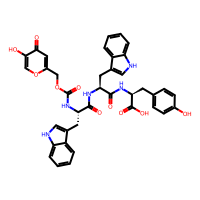
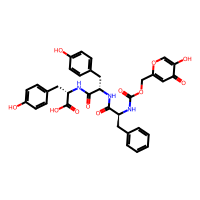
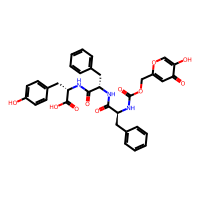
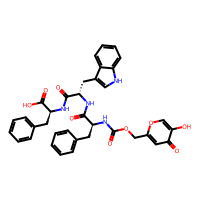
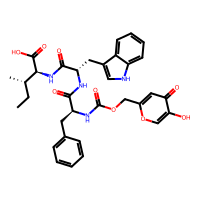
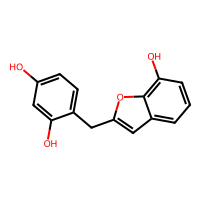
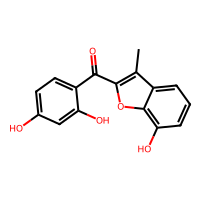
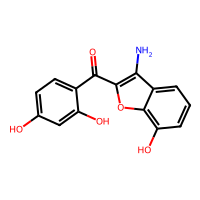
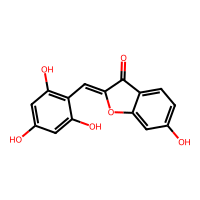
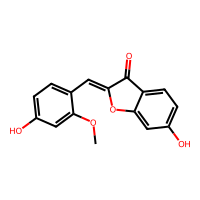

In [31]:
pattern_fenol = Chem.MolFromSmarts('c1ccccc1O')

def tiene_fenol(mol):
    return mol.HasSubstructMatch(pattern_fenol)

df_clean['Grupo_Fenol'] = df_clean['ROMol'].apply(lambda m: tiene_fenol(m) if m else False)

df_clean['Fenol_bit'] = df_clean['Grupo_Fenol'].astype(int)
replacement = {"Active":1,"Inactive":0}
df_clean["Activity"] = df_clean["Activity"].map(replacement)

df_clean

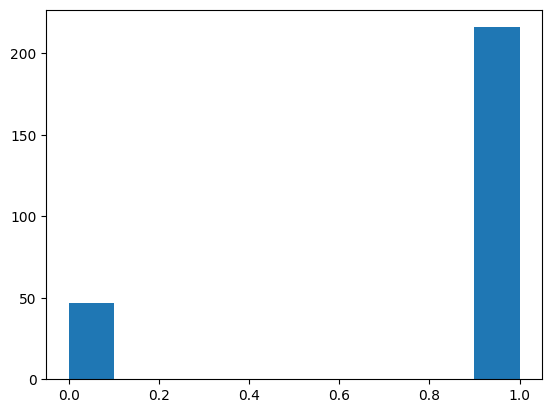

In [32]:
plt.hist(df_clean['Fenol_bit'], bins=None, range=None, density=False, histtype='bar', color=None, label=None)
plt.show()

In [33]:
df_clean.columns

Index(['ID', 'SMILES', 'IC50', 'ROMol', 'Activity', 'NumAtoms', 'MolWeight',
       'Rings', 'FpDM1', 'RotBonds', 'TPSA', 'LogP', 'NumHAcceptors',
       'NumHDonors', 'HeavyAtomCount', 'Cluster_fingerprints', 'Grupo_Fenol',
       'Fenol_bit'],
      dtype='object')

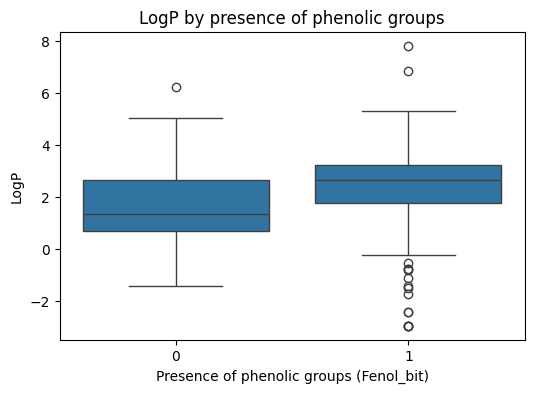

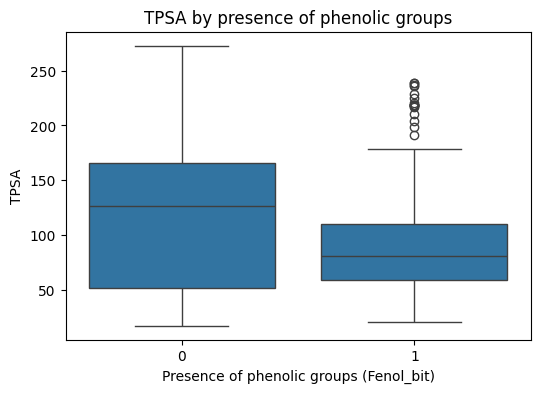

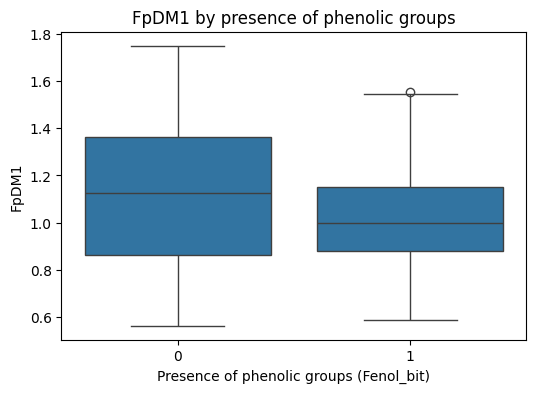

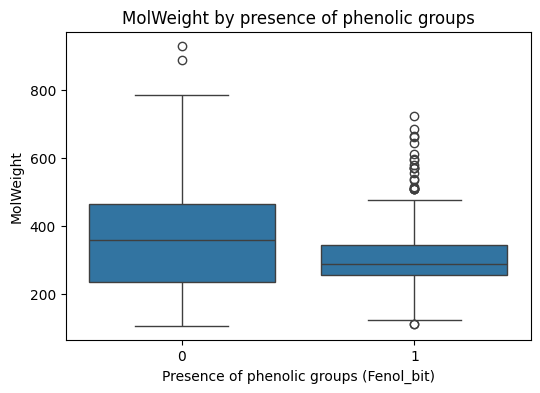

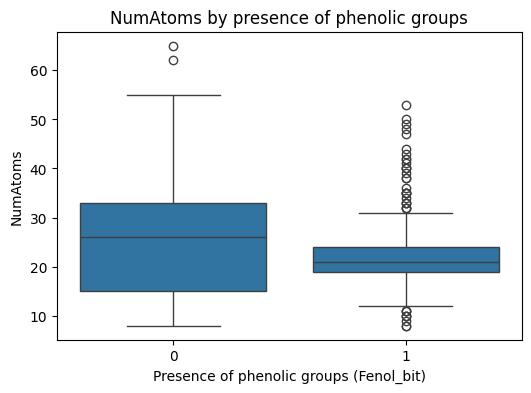

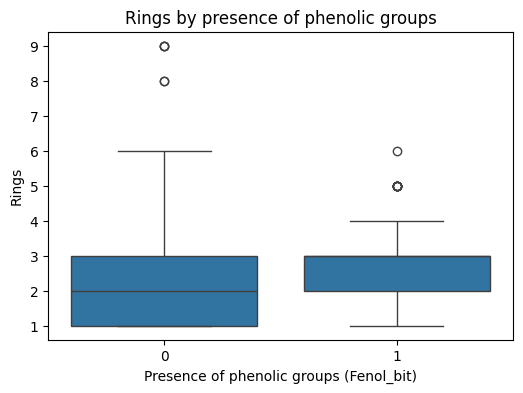

In [35]:
columns_to_compare = ['LogP', 'TPSA', 'FpDM1', 'MolWeight', 'NumAtoms', 'Rings']

for col in columns_to_compare:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_clean, x='Fenol_bit', y=col)
    plt.xlabel('Presence of phenolic groups (Fenol_bit)')
    plt.ylabel(col)
    plt.title(f'{col} by presence of phenolic groups')
    plt.show()

### Pearmibility Roule

In [36]:
df_cutanea = df_clean[['LogP', 'MolWeight', 'TPSA', 'NumHAcceptors', 'NumHDonors', 'Fenol_bit']].copy()

df_cutanea['LogP_ok'] = (df_cutanea['LogP'] >= 1) & (df_cutanea['LogP'] <= 3)
df_cutanea['MolWeight_ok'] = df_cutanea['MolWeight'] < 500
df_cutanea['TPSA_ok'] = df_cutanea['TPSA'] < 90
df_cutanea['HBA_ok'] = df_cutanea['NumHAcceptors'] < 10
df_cutanea['HBD_ok'] = df_cutanea['NumHDonors'] < 5
df_cutanea['Fenol_ok'] = df_cutanea['Fenol_bit'] == 1

In [37]:
df_cutanea

,LogP,MolWeight,TPSA,NumHAcceptors,NumHDonors,Fenol_bit,LogP_ok,MolWeight_ok,TPSA_ok,HBA_ok,HBD_ok,Fenol_ok
0,3.39070,721.723,236.08,9,8,1,False,False,False,True,False,True
1,2.13370,659.648,224.73,10,7,1,True,False,False,False,False,True
2,2.42810,643.649,204.50,9,6,1,True,False,False,True,False,True
3,3.20380,666.687,200.06,8,6,0,False,False,False,True,False,False
4,3.00720,632.670,200.06,8,6,0,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
258,3.14040,256.257,73.83,4,3,1,False,True,True,True,True,True
259,3.08902,284.267,90.90,5,3,1,False,True,False,True,True,True
260,2.36280,285.255,116.92,6,4,1,True,True,False,True,True,True
261,2.12520,286.239,107.22,6,4,1,True,True,False,True,True,True


In [38]:
df_cutanea['Permeability'] = (
    (df_cutanea['LogP'] >= 1) & (df_cutanea['LogP'] <= 3) &
    (df_cutanea['MolWeight'] < 500) &
    (df_cutanea['TPSA'] < 90) &
    (df_cutanea['NumHAcceptors'] < 10) &
    (df_cutanea['NumHDonors'] < 5) &
    (df_cutanea['Fenol_bit'] == 1)
)

In [39]:
df_cutanea['Permeability'].value_counts()

,count
Permeability,
False,183
True,80


# Machine Learning

In [40]:

X = df_clean[['NumAtoms', 'MolWeight', 'Rings', 'TPSA', 'FpDM1', 'Fenol_bit', 'LogP']]
y = df_clean['Activity']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
o
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=0, stratify=y_temp)


In [41]:
def value_counts(series, value):
    return (series == value).sum()

counts = value_counts(y_test, 1)
print(f"There are {counts} active compounds in the test set")

cantidad = value_counts(y_val, 1)
print(f"There are {counts} active compounds in the validation set")

cantidad = value_counts(y_train, 1)
print(f"There are {counts} active compounds in the training set")


There are 4 active compounds in the test set
There are 4 active compounds in the validation set
There are 4 active compounds in the training set


In [42]:
print(X_test.shape)
print(X_train.shape)
print(X_val.shape)

(53, 7)
(157, 7)
(53, 7)


In [43]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val= pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

### Features Importance

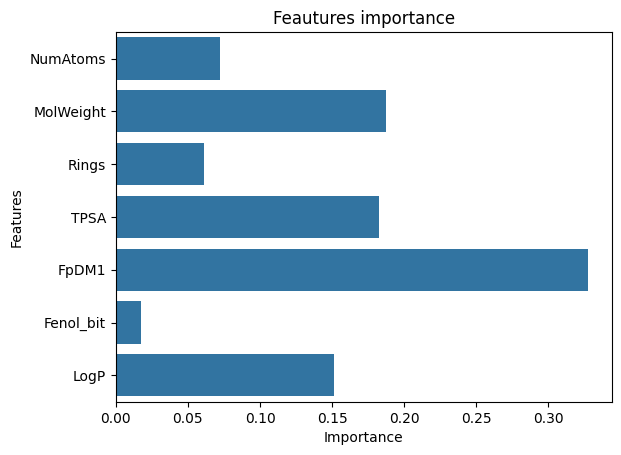

In [45]:
rf = RandomForestClassifier(n_estimators=5, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_

sns.barplot(x=importances, y=X_train.columns)
plt.title("Feautures importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()



Accuracy: 0.9056603773584906


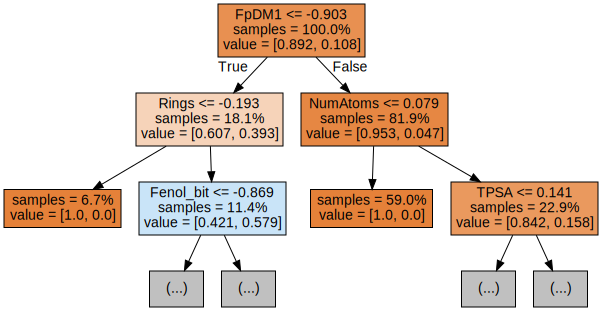

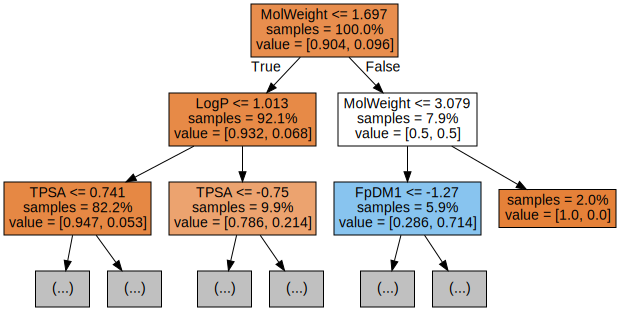

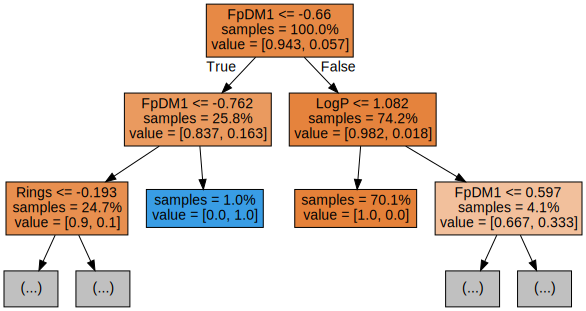

In [46]:
# Modelling

y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
y_pred_val= rf.predict(X_val)

# Metrics
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

# Trees Validation
from sklearn.tree import export_graphviz
import graphviz
for i in range(min(3, len(rf.estimators_))):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)


In [47]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Evaluamos el modelo

print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Accuracy on training data:", accuracy_score(y_train, y_pred_train))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", precision_score(y_test, y_pred_test))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", recall_score(y_test, y_pred_test))

print("\nClassification Report:\n", classification_report(y_val, y_pred_val))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_val))

Accuracy: 0.9056603773584906
Accuracy on training data: 0.9745222929936306
Precision: 0.3333333333333333
Recall: 0.25

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        49
           1       0.50      0.50      0.50         4

    accuracy                           0.92        53
   macro avg       0.73      0.73      0.73        53
weighted avg       0.92      0.92      0.92        53


Confusion Matrix:
 [[47  2]
 [ 2  2]]


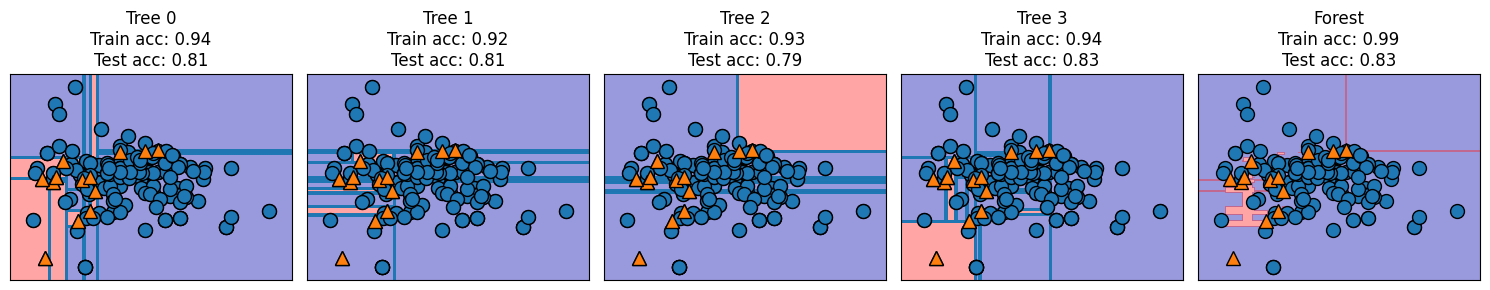

In [48]:
# Second Random Forest Training, only 2 descriptors
X_train_2d = X_train[['FpDM1', 'LogP']]
X_test_2d = X_test[['FpDM1', 'LogP']]

rf_2d = RandomForestClassifier(n_estimators=5, random_state=0)
rf_2d.fit(X_train_2d, y_train)

# Grafics
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    ax1 = axes[i]

    if i != 4:
        tree = rf_2d.estimators_[i]
        y_pred_train = tree.predict(X_train_2d.values)
        y_pred_test = tree.predict(X_test_2d.values)

        mglearn.plots.plot_tree_partition(X_train_2d.values, y_train, tree, ax=ax1)
        mglearn.discrete_scatter(X_train_2d.iloc[:, 0], X_train_2d.iloc[:, 1], y_train, ax=ax1)
        ax1.set_title(f"Tree {i}\nTrain acc: {round(accuracy_score(y_train, y_pred_train), 2)}\nTest acc: {round(accuracy_score(y_test, y_pred_test), 2)}")

    else:
        y_pred_train_rf = rf_2d.predict(X_train_2d.values)
        y_pred_test_rf = rf_2d.predict(X_test_2d.values)

        mglearn.plots.plot_2d_separator(rf_2d, X_train_2d.values, fill=True, ax=ax1, alpha=0.4)
        mglearn.discrete_scatter(X_train_2d.iloc[:, 0], X_train_2d.iloc[:, 1], y_train, ax=ax1)
        ax1.set_title(f"Forest\nTrain acc: {round(accuracy_score(y_train, y_pred_train_rf), 2)}\nTest acc: {round(accuracy_score(y_test, y_pred_test_rf), 2)}")

fig.tight_layout()
plt.show()


In [49]:
X_train_2d = X_train[['FpDM1', 'LogP']]
X_test_2d = X_test[['FpDM1', 'LogP']]
X_val_2d = X_val[['FpDM1', 'LogP']]

# Predcitions
y_pred_2d_test = rf_2d.predict(X_test_2d)
y_pred_2d_train = rf_2d.predict(X_train_2d)
y_pred_2d_val= rf_2d.predict(X_val_2d)

# Metrics
accuracy = accuracy_score(y_test, y_pred_2d_test)
print("Accuracy:", accuracy)


Accuracy: 0.8301886792452831


In [50]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred_2d_test))
print("Accuracy on training data:", accuracy_score(y_train, y_pred_2d_train))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", precision_score(y_test, y_pred_2d_test))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", recall_score(y_test, y_pred_2d_test))

print("\nClassification Report:\n", classification_report(y_val, y_pred_2d_val))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_2d_val))

Accuracy: 0.8301886792452831
Accuracy on training data: 0.9872611464968153
Precision: 0.0
Recall: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        49
           1       0.00      0.00      0.00         4

    accuracy                           0.85        53
   macro avg       0.46      0.46      0.46        53
weighted avg       0.85      0.85      0.85        53


Confusion Matrix:
 [[45  4]
 [ 4  0]]


### Applying Model

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
apl_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Quimioinformatica/huskinDB (1).csv')

In [54]:
apl_df

,Compound name,Smiles,logkp (cm/s),skin donor type,skin source site,used layer,skin preparation,storage temperature (°C),storage duration (days),neat,...,donor pH,donor type,acceptor temperature (°C),acceptor pH,acceptor type,cell type,flux,notes,reference,DOI
0,"1,1,1-Trichloropropanone",CC(=O)C(Cl)(Cl)Cl,-5.176,Mammaplasty,breast,"epidermis, dermis",dermatomed 250-280um,-20.0,NaN,0,...,7.0,Water,37.0,7.4,PBS,Glass diffusion cell,NaN,NaN,"Xu, 2002",10.1006/taap.2002.9494
1,"1,1-Dichloropropanone",ClC(C(=O)C)Cl,-4.923,Mammaplasty,breast,"epidermis, dermis",dermatomed 250-280um,-20.0,NaN,0,...,7.0,Water,37.0,7.4,PBS,Glass diffusion cell,NaN,NaN,"Xu, 2002",10.1006/taap.2002.9494
2,"1,2,4-Benzenetriol",Oc1ccc(c(c1)O)O,-7.456,Abdominoplasty,abdomen,epidermis,heat separation,-17.0,NaN,0,...,NaN,Water,37.0,7.4,PBS,Franz cell,NaN,NaN,"du Plessis, 2002",10.1016/S0928-0987(02)00085-4
3,"1,6-hexanediol diglycidyl ether",C(CCOCC1OC1)CCCOCC1OC1,-7.423,Mammaplasty,breast,"epidermis, dermis",dermatomed,NaN,0.125,0,...,NaN,NaN,NaN,7.4,Hanks balanced salt solution,Flow through cell,NaN,"receptor- Hanks balanced salt solution, no phe...","Boogaard, 2000",10.1080/004982500237488
4,1-Butanol,CCCCO,-6.079,Cadaver,abdomen,epidermis,heat separation,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,Glass diffusion cell,NaN,kp value given as a range (2-4*10^-3 cm/h); me...,"Blank, 1967",10.1038/jid.1967.184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,Water,O,-6.429,Cadaver,abdomen,"epidermis, dermis",dermatomed 420um,-24.0,NaN,0,...,NaN,Water,31.0,NaN,Sodium azide,Flow through cell,NaN,NaN,"Rigg, 1990",10.1111/1523-1747.ep12874561
546,Water,O,-5.240,Surgery,scalp,"epidermis, dermis","dermatomed 420um, hydrated 10d",-20.0,210,0,...,NaN,NaN,31.0,NaN,Sodium azide,NaN,NaN,10 day experiment,"Bond, 1988",10.1111/1523-1747.ep12460958
547,Water,O,-6.426,Cadaver,abdomen,"epidermis, dermis","dermatomed 420um, hydrated 1.75d",-20.0,210,0,...,NaN,NaN,31.0,NaN,Sodium azide,NaN,NaN,1.74 day experiment,"Bond, 1988",10.1111/1523-1747.ep12460958
548,Water,O,-6.751,Cadaver,abdomen,NaN,NaN,7.0,4,0,...,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,"Scott, 1990",10.1111/1523-1747.ep12475447


In [55]:
remover= SaltRemover.SaltRemover()
apl_df['Smiles'] = apl_df['Smiles'].progress_apply(lambda x: remover.StripMol(Chem.MolFromSmiles(x), dontRemoveEverything=True))

  0%|          | 0/550 [00:00<?, ?it/s]

In [56]:
SMILES = []
for index,row in apl_df.iterrows():
  molecula = row['Smiles']
  SMILES.append(Chem.MolToSmiles(molecula))

apl_df['SMILES'] = SMILES

apl_df

,Compound name,Smiles,logkp (cm/s),skin donor type,skin source site,used layer,skin preparation,storage temperature (°C),storage duration (days),neat,...,donor type,acceptor temperature (°C),acceptor pH,acceptor type,cell type,flux,notes,reference,DOI,SMILES
0,"1,1,1-Trichloropropanone",<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66c70>,-5.176,Mammaplasty,breast,"epidermis, dermis",dermatomed 250-280um,-20.0,NaN,0,...,Water,37.0,7.4,PBS,Glass diffusion cell,NaN,NaN,"Xu, 2002",10.1006/taap.2002.9494,CC(=O)C(Cl)(Cl)Cl
1,"1,1-Dichloropropanone",<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66d50>,-4.923,Mammaplasty,breast,"epidermis, dermis",dermatomed 250-280um,-20.0,NaN,0,...,Water,37.0,7.4,PBS,Glass diffusion cell,NaN,NaN,"Xu, 2002",10.1006/taap.2002.9494,CC(=O)C(Cl)Cl
2,"1,2,4-Benzenetriol",<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66ea0>,-7.456,Abdominoplasty,abdomen,epidermis,heat separation,-17.0,NaN,0,...,Water,37.0,7.4,PBS,Franz cell,NaN,NaN,"du Plessis, 2002",10.1016/S0928-0987(02)00085-4,Oc1ccc(O)c(O)c1
3,"1,6-hexanediol diglycidyl ether",<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66340>,-7.423,Mammaplasty,breast,"epidermis, dermis",dermatomed,NaN,0.125,0,...,NaN,NaN,7.4,Hanks balanced salt solution,Flow through cell,NaN,"receptor- Hanks balanced salt solution, no phe...","Boogaard, 2000",10.1080/004982500237488,C(CCCOCC1CO1)CCOCC1CO1
4,1-Butanol,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b650e0>,-6.079,Cadaver,abdomen,epidermis,heat separation,NaN,NaN,0,...,NaN,NaN,NaN,NaN,Glass diffusion cell,NaN,kp value given as a range (2-4*10^-3 cm/h); me...,"Blank, 1967",10.1038/jid.1967.184,CCCCO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,Water,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b90900>,-6.429,Cadaver,abdomen,"epidermis, dermis",dermatomed 420um,-24.0,NaN,0,...,Water,31.0,NaN,Sodium azide,Flow through cell,NaN,NaN,"Rigg, 1990",10.1111/1523-1747.ep12874561,O
546,Water,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b90c10>,-5.240,Surgery,scalp,"epidermis, dermis","dermatomed 420um, hydrated 10d",-20.0,210,0,...,NaN,31.0,NaN,Sodium azide,NaN,NaN,10 day experiment,"Bond, 1988",10.1111/1523-1747.ep12460958,O
547,Water,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b90eb0>,-6.426,Cadaver,abdomen,"epidermis, dermis","dermatomed 420um, hydrated 1.75d",-20.0,210,0,...,NaN,31.0,NaN,Sodium azide,NaN,NaN,1.74 day experiment,"Bond, 1988",10.1111/1523-1747.ep12460958,O
548,Water,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b91230>,-6.751,Cadaver,abdomen,NaN,NaN,7.0,4,0,...,NaN,30.0,NaN,NaN,NaN,NaN,NaN,"Scott, 1990",10.1111/1523-1747.ep12475447,O


In [57]:

INCHI = []
for index,row in apl_df.iterrows():
  molecula = row['Smiles']
  INCHI.append(Chem.MolToInchi(molecula))

apl_df['Inchi'] = INCHI

apl_df = apl_df.drop_duplicates(subset='Inchi')
apl_df

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Charges were rearranged

[02:48:54] WARNING: Charges were rearranged

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Charges were rearranged

[02:48:54] WARNING: Charges were rearranged

[02:48:54] WARNING: Charges were rearranged

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined stereo

[02:48:54] WARNING: Omitted undefined s

,Compound name,Smiles,logkp (cm/s),skin donor type,skin source site,used layer,skin preparation,storage temperature (°C),storage duration (days),neat,...,acceptor temperature (°C),acceptor pH,acceptor type,cell type,flux,notes,reference,DOI,SMILES,Inchi
0,"1,1,1-Trichloropropanone",<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66c70>,-5.176,Mammaplasty,breast,"epidermis, dermis",dermatomed 250-280um,-20.0,NaN,0,...,37.0,7.4,PBS,Glass diffusion cell,NaN,NaN,"Xu, 2002",10.1006/taap.2002.9494,CC(=O)C(Cl)(Cl)Cl,"InChI=1S/C3H3Cl3O/c1-2(7)3(4,5)6/h1H3"
1,"1,1-Dichloropropanone",<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66d50>,-4.923,Mammaplasty,breast,"epidermis, dermis",dermatomed 250-280um,-20.0,NaN,0,...,37.0,7.4,PBS,Glass diffusion cell,NaN,NaN,"Xu, 2002",10.1006/taap.2002.9494,CC(=O)C(Cl)Cl,"InChI=1S/C3H4Cl2O/c1-2(6)3(4)5/h3H,1H3"
2,"1,2,4-Benzenetriol",<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66ea0>,-7.456,Abdominoplasty,abdomen,epidermis,heat separation,-17.0,NaN,0,...,37.0,7.4,PBS,Franz cell,NaN,NaN,"du Plessis, 2002",10.1016/S0928-0987(02)00085-4,Oc1ccc(O)c(O)c1,"InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H"
3,"1,6-hexanediol diglycidyl ether",<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66340>,-7.423,Mammaplasty,breast,"epidermis, dermis",dermatomed,NaN,0.125,0,...,NaN,7.4,Hanks balanced salt solution,Flow through cell,NaN,"receptor- Hanks balanced salt solution, no phe...","Boogaard, 2000",10.1080/004982500237488,C(CCCOCC1CO1)CCOCC1CO1,InChI=1S/C12H22O4/c1(3-5-13-7-11-9-15-11)2-4-6...
4,1-Butanol,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b650e0>,-6.079,Cadaver,abdomen,epidermis,heat separation,NaN,NaN,0,...,NaN,NaN,NaN,Glass diffusion cell,NaN,kp value given as a range (2-4*10^-3 cm/h); me...,"Blank, 1967",10.1038/jid.1967.184,CCCCO,"InChI=1S/C4H10O/c1-2-3-4-5/h5H,2-4H2,1H3"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,Triclosan,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b91c40>,-7.269,Abdominoplasty or mammaplasty,"abdomen, breast","epidermis, dermis",dermatomed 230um,NaN,NaN,0,...,32.0,7.3,Eagle Minimal Essential Medium with Earle's sa...,Flow through cell,Jss= 12.5 umol/(cm^2*h); c=64.5mM,NaN,"Moss, 2000",10.1016/S0278-6915(99)00164-7,Oc1cc(Cl)ccc1Oc1ccc(Cl)cc1Cl,InChI=1S/C12H7Cl3O2/c13-7-1-3-11(9(15)5-7)17-1...
531,Triglycol nicotinate,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8fa70>,-8.561,Abdominoplasty or mammaplasty,"abdomen, breast",epidermis,heat separation,4.0,NaN,0,...,37.0,NaN,PBS,Franz cell,Jss= 0.99 ug/(cm^2*h); c=100mg/m,NaN,"Dalpozzo, 1991",10.1002/jps.2600800114,O=C(OCCOCCOCCO)c1cccnc1,InChI=1S/C12H17NO5/c14-4-5-16-6-7-17-8-9-18-12...
532,Trimethylamine,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8ece0>,-7.284,Abdominoplasty,abdomen,"epidermis, dermis",fat removed,-20.0,NaN,0,...,32.0,7.3,Hanks balanced salt solution,Flow through cell,NaN,NaN,"Kenyon, 2004",10.1016/j.fct.2004.05.007,CN(C)C,InChI=1S/C3H9N/c1-4(2)3/h1-3H3
533,Urea,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8d4d0>,-7.386,Cadaver,NaN,stratum corneum,heat separation,4.0,2,0,...,37.0,7.1,Dulbecco PBS,Franz cell,NaN,also stored at -70 deg. C,"Barber, 1992",10.1016/0272-0590(92)90086-W,NC(N)=O,"InChI=1S/CH4N2O/c2-1(3)4/h(H4,2,3,4)"


In [58]:
num_atoms = []
mol_weight = []
rings = []
fpdm1 = []
rot_bonds = []
tpsa = []
logp = []
num_h_acceptors = []
num_h_donors = []
heavy_atom_count = []
SMILES = []
molecula = []

for index, row in apl_df.iterrows():
    mol = row['Smiles']
    if mol:
        molecula.append(mol)
        SMILES.append(Chem.MolToSmiles(mol))
        num_atoms.append(len(mol.GetAtoms()))
        mol_weight.append(Descriptors.MolWt(mol))
        rings.append(Descriptors.RingCount(mol))
        fpdm1.append(Descriptors.FpDensityMorgan1(mol))
        rot_bonds.append(Descriptors.NumRotatableBonds(mol))
        tpsa.append(Descriptors.TPSA(mol))
        logp.append(Descriptors.MolLogP(mol))
        num_h_acceptors.append(Descriptors.NumHAcceptors(mol))
        num_h_donors.append(Descriptors.NumHDonors(mol))
        heavy_atom_count.append(Descriptors.HeavyAtomCount(mol))
    else:
        molecula.append(None)
        SMILES.append(None)
        num_atoms.append(None)
        mol_weight.append(None)
        rings.append(None)
        fpdm1.append(None)
        rot_bonds.append(None)
        tpsa.append(None)
        logp.append(None)
        num_h_acceptors.append(None)
        num_h_donors.append(None)
        heavy_atom_count.append(None)

apl_clean = pd.DataFrame({
    'Mol': molecula,
    'SMILES': SMILES,
    'NumAtoms': num_atoms,
    'MolWeight': mol_weight,
    'Rings': rings,
    'FpDM1': fpdm1,
    'RotBonds': rot_bonds,
    'TPSA': tpsa,
    'LogP': logp,
    'NumHAcceptors': num_h_acceptors,
    'NumHDonors': num_h_donors,
    'HeavyAtomCount':heavy_atom_count,
})

apl_clean

,Mol,SMILES,NumAtoms,MolWeight,Rings,FpDM1,RotBonds,TPSA,LogP,NumHAcceptors,NumHDonors,HeavyAtomCount
0,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66c70>,CC(=O)C(Cl)(Cl)Cl,7,161.415,0,1.428571,0,17.07,1.9456,1,0,7
1,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66d50>,CC(=O)C(Cl)Cl,6,126.970,0,1.666667,1,17.07,1.3791,1,0,6
2,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66ea0>,Oc1ccc(O)c(O)c1,9,126.111,1,0.888889,0,60.69,0.8034,3,3,9
3,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66340>,C(CCCOCC1CO1)CCOCC1CO1,16,230.304,2,0.750000,11,43.52,1.3776,4,0,16
4,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b650e0>,CCCCO,5,74.123,0,1.600000,2,20.23,0.7788,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
247,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b91c40>,Oc1cc(Cl)ccc1Oc1ccc(Cl)cc1Cl,17,289.545,2,0.823529,2,29.46,5.1447,2,1,17
248,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8fa70>,O=C(OCCOCCOCCO)c1cccnc1,18,255.270,1,1.166667,9,77.88,0.2639,6,1,18
249,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8ece0>,CN(C)C,4,59.112,0,1.000000,0,3.24,0.1778,1,0,4
250,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8d4d0>,NC(N)=O,4,60.056,0,1.500000,0,69.11,-0.9762,1,2,4


In [59]:
#Smiles pattern for fenol
pattern_fenol = Chem.MolFromSmarts('c[OH]')

# Fenol detection
def has_fenol(mol):
    return mol.HasSubstructMatch(pattern_fenol)


apl_clean['Grupo_Fenol'] = apl_clean['Mol'].apply(lambda m: tiene_fenol(m) if m else False)

# Boolean convertion
apl_clean['Fenol_bit'] = apl_clean['Grupo_Fenol'].astype(int)

apl_clean

,Mol,SMILES,NumAtoms,MolWeight,Rings,FpDM1,RotBonds,TPSA,LogP,NumHAcceptors,NumHDonors,HeavyAtomCount,Grupo_Fenol,Fenol_bit
0,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66c70>,CC(=O)C(Cl)(Cl)Cl,7,161.415,0,1.428571,0,17.07,1.9456,1,0,7,False,0
1,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66d50>,CC(=O)C(Cl)Cl,6,126.970,0,1.666667,1,17.07,1.3791,1,0,6,False,0
2,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66ea0>,Oc1ccc(O)c(O)c1,9,126.111,1,0.888889,0,60.69,0.8034,3,3,9,True,1
3,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66340>,C(CCCOCC1CO1)CCOCC1CO1,16,230.304,2,0.750000,11,43.52,1.3776,4,0,16,False,0
4,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b650e0>,CCCCO,5,74.123,0,1.600000,2,20.23,0.7788,1,1,5,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b91c40>,Oc1cc(Cl)ccc1Oc1ccc(Cl)cc1Cl,17,289.545,2,0.823529,2,29.46,5.1447,2,1,17,True,1
248,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8fa70>,O=C(OCCOCCOCCO)c1cccnc1,18,255.270,1,1.166667,9,77.88,0.2639,6,1,18,False,0
249,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8ece0>,CN(C)C,4,59.112,0,1.000000,0,3.24,0.1778,1,0,4,False,0
250,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8d4d0>,NC(N)=O,4,60.056,0,1.500000,0,69.11,-0.9762,1,2,4,False,0


In [60]:
apl_clean['Grupo_Fenol'].value_counts()

,count
Grupo_Fenol,
False,203
True,49


In [61]:
apl_clean['Fenol_bit'].value_counts()

,count
Fenol_bit,
0,203
1,49


In [62]:
X_nuevo = apl_clean[['NumAtoms', 'MolWeight', 'Rings', 'TPSA', 'FpDM1', 'Fenol_bit', 'LogP']]
predicciones = rf.predict(X_nuevo)

print('The number of molecules predicted as inhibitors is:', sum(predicciones))

apl_clean['predicciones'] = predicciones

print(apl_clean[apl_clean['predicciones'] == 1])


The number of molecules predicted as inhibitors is: 0
Empty DataFrame
Columns: [Mol, SMILES, NumAtoms, MolWeight, Rings, FpDM1, RotBonds, TPSA, LogP, NumHAcceptors, NumHDonors, HeavyAtomCount, Grupo_Fenol, Fenol_bit, predicciones]
Index: []


In [63]:
X_nuevo_2d = apl_clean[['FpDM1', 'LogP']]
predicciones_2d = rf_2d.predict(X_nuevo_2d)

print('The number of molecules predicted as inhibitors is:', sum(predicciones_2d))

apl_clean['predicciones_2d'] = predicciones_2d

print(apl_clean[apl_clean['predicciones_2d'] == 1])


The number of molecules predicted as inhibitors is: 8
                                                  Mol  \
3    <rdkit.Chem.rdchem.Mol object at 0x7e73d8b66340>   
62   <rdkit.Chem.rdchem.Mol object at 0x7e73d8b83990>   
64   <rdkit.Chem.rdchem.Mol object at 0x7e73d8b67ca0>   
80   <rdkit.Chem.rdchem.Mol object at 0x7e73d8b82b20>   
153  <rdkit.Chem.rdchem.Mol object at 0x7e73d8b8af80>   
208  <rdkit.Chem.rdchem.Mol object at 0x7e73d8b8d8c0>   
233  <rdkit.Chem.rdchem.Mol object at 0x7e73d8b90510>   
234  <rdkit.Chem.rdchem.Mol object at 0x7e73d8b8fd10>   

                                        SMILES  NumAtoms  MolWeight  Rings  \
3                       C(CCCOCC1CO1)CCOCC1CO1        16    230.304      2   
62    CCCCC(CC)COC(=O)c1ccccc1C(=O)OCC(CC)CCCC        28    390.564      1   
64   CC(C)(c1ccc(OCC2CO2)cc1)c1ccc(OCC2CO2)cc1        25    340.419      4   
80                                  Oc1ccccc1O         8    110.112      1   
153                               Oc1ccc(O

In [64]:
apl_cutanea = apl_clean[apl_clean['predicciones_2d'] == 1].copy()

apl_cutanea

,Mol,SMILES,NumAtoms,MolWeight,Rings,FpDM1,RotBonds,TPSA,LogP,NumHAcceptors,NumHDonors,HeavyAtomCount,Grupo_Fenol,Fenol_bit,predicciones,predicciones_2d
3,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66340>,C(CCCOCC1CO1)CCOCC1CO1,16,230.304,2,0.750,11,43.52,1.3776,4,0,16,False,0,0,1
62,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b83990>,CCCCC(CC)COC(=O)c1ccccc1C(=O)OCC(CC)CCCC,28,390.564,1,0.750,14,52.60,6.4330,4,0,28,False,0,0,1
64,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b67ca0>,CC(C)(c1ccc(OCC2CO2)cc1)c1ccc(OCC2CO2)cc1,25,340.419,4,0.760,8,43.52,3.5677,4,0,25,False,0,0,1
80,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b82b20>,Oc1ccccc1O,8,110.112,1,0.875,0,40.46,1.0978,2,2,8,True,1,0,1
153,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8af80>,Oc1ccc(O)cc1,8,110.112,1,0.750,0,40.46,1.0978,2,2,8,True,1,0,1
208,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8d8c0>,CCCCCCCCC=CCCCCCCCC(=O)O,20,282.468,0,0.750,15,37.30,6.1085,1,1,20,False,0,0,1
233,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b90510>,Oc1cccc(O)c1,8,110.112,1,1.000,0,40.46,1.0978,2,2,8,True,1,0,1
234,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8fd10>,O=C(O)c1ccccc1O,10,138.122,1,1.300,1,57.53,1.0904,2,2,10,True,1,0,1


In [65]:
# Permeability
mol_weight = []
tpsa = []
num_h_acceptors = []
num_h_donors = []
heavy_atom_count = []

for index, row in apl_cutanea.iterrows():
    mol = row['Mol']
    if mol:
        mol_weight.append(Descriptors.MolWt(mol))
        tpsa.append(Descriptors.TPSA(mol))
        num_h_acceptors.append(Descriptors.NumHAcceptors(mol))
        num_h_donors.append(Descriptors.NumHDonors(mol))
        heavy_atom_count.append(Descriptors.HeavyAtomCount(mol))
    else:
        mol_weight.append(None)
        tpsa.append(None)
        num_h_acceptors.append(None)
        num_h_donors.append(None)
        heavy_atom_count.append(None)

apl_cutanea['MolWeight'] = mol_weight
apl_cutanea['TPSA'] = tpsa
apl_cutanea['NumHAcceptors'] = num_h_acceptors
apl_cutanea['NumHDonors'] = num_h_donors

apl_cutanea

,Mol,SMILES,NumAtoms,MolWeight,Rings,FpDM1,RotBonds,TPSA,LogP,NumHAcceptors,NumHDonors,HeavyAtomCount,Grupo_Fenol,Fenol_bit,predicciones,predicciones_2d
3,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66340>,C(CCCOCC1CO1)CCOCC1CO1,16,230.304,2,0.750,11,43.52,1.3776,4,0,16,False,0,0,1
62,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b83990>,CCCCC(CC)COC(=O)c1ccccc1C(=O)OCC(CC)CCCC,28,390.564,1,0.750,14,52.60,6.4330,4,0,28,False,0,0,1
64,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b67ca0>,CC(C)(c1ccc(OCC2CO2)cc1)c1ccc(OCC2CO2)cc1,25,340.419,4,0.760,8,43.52,3.5677,4,0,25,False,0,0,1
80,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b82b20>,Oc1ccccc1O,8,110.112,1,0.875,0,40.46,1.0978,2,2,8,True,1,0,1
153,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8af80>,Oc1ccc(O)cc1,8,110.112,1,0.750,0,40.46,1.0978,2,2,8,True,1,0,1
208,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8d8c0>,CCCCCCCCC=CCCCCCCCC(=O)O,20,282.468,0,0.750,15,37.30,6.1085,1,1,20,False,0,0,1
233,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b90510>,Oc1cccc(O)c1,8,110.112,1,1.000,0,40.46,1.0978,2,2,8,True,1,0,1
234,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8fd10>,O=C(O)c1ccccc1O,10,138.122,1,1.300,1,57.53,1.0904,2,2,10,True,1,0,1


In [66]:
pattern_fenol = Chem.MolFromSmarts('c1ccccc1O')

def tiene_fenol(mol):
    return mol.HasSubstructMatch(pattern_fenol)

apl_cutanea['Grupo_Fenol'] = apl_cutanea['Mol'].apply(lambda m: tiene_fenol(m) if m else False)

# Convertir a (0 o 1)
apl_cutanea['Fenol_bit'] = apl_cutanea['Grupo_Fenol'].astype(int)

apl_cutanea

,Mol,SMILES,NumAtoms,MolWeight,Rings,FpDM1,RotBonds,TPSA,LogP,NumHAcceptors,NumHDonors,HeavyAtomCount,Grupo_Fenol,Fenol_bit,predicciones,predicciones_2d
3,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b66340>,C(CCCOCC1CO1)CCOCC1CO1,16,230.304,2,0.750,11,43.52,1.3776,4,0,16,False,0,0,1
62,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b83990>,CCCCC(CC)COC(=O)c1ccccc1C(=O)OCC(CC)CCCC,28,390.564,1,0.750,14,52.60,6.4330,4,0,28,False,0,0,1
64,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b67ca0>,CC(C)(c1ccc(OCC2CO2)cc1)c1ccc(OCC2CO2)cc1,25,340.419,4,0.760,8,43.52,3.5677,4,0,25,True,1,0,1
80,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b82b20>,Oc1ccccc1O,8,110.112,1,0.875,0,40.46,1.0978,2,2,8,True,1,0,1
153,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8af80>,Oc1ccc(O)cc1,8,110.112,1,0.750,0,40.46,1.0978,2,2,8,True,1,0,1
208,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8d8c0>,CCCCCCCCC=CCCCCCCCC(=O)O,20,282.468,0,0.750,15,37.30,6.1085,1,1,20,False,0,0,1
233,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b90510>,Oc1cccc(O)c1,8,110.112,1,1.000,0,40.46,1.0978,2,2,8,True,1,0,1
234,<rdkit.Chem.rdchem.Mol object at 0x7e73d8b8fd10>,O=C(O)c1ccccc1O,10,138.122,1,1.300,1,57.53,1.0904,2,2,10,True,1,0,1


In [67]:
apl_cutanea['LogP_ok'] = (apl_cutanea['LogP'] >= 1) & (df_cutanea['LogP'] <= 3)
apl_cutanea['MolWeight_ok'] = apl_cutanea['MolWeight'] < 500
apl_cutanea['TPSA_ok'] = apl_cutanea['TPSA'] < 90
apl_cutanea['HBA_ok'] = apl_cutanea['NumHAcceptors'] < 10
apl_cutanea['HBD_ok'] = apl_cutanea['NumHDonors'] < 5
apl_cutanea['Fenol_ok'] = apl_cutanea['Fenol_bit'] == 1

In [68]:
apl_cutanea['Permeability'] = (
    (apl_cutanea['LogP'] >= 1) & (apl_cutanea['LogP'] <= 3) &
    (apl_cutanea['MolWeight'] < 500) &
    (apl_cutanea['TPSA'] < 90) &
    (apl_cutanea['NumHAcceptors'] < 10) &
    (apl_cutanea['NumHDonors'] < 5) &
    (apl_cutanea['Fenol_bit'] == 1)
)

In [69]:
apl_cutanea['Permeability'].value_counts()

,count
Permeability,
False,4
True,4


In [71]:
print(apl_cutanea[apl_cutanea['Permeability'] == True])

                                                  Mol           SMILES  \
80   <rdkit.Chem.rdchem.Mol object at 0x7e73d8b82b20>       Oc1ccccc1O   
153  <rdkit.Chem.rdchem.Mol object at 0x7e73d8b8af80>     Oc1ccc(O)cc1   
233  <rdkit.Chem.rdchem.Mol object at 0x7e73d8b90510>     Oc1cccc(O)c1   
234  <rdkit.Chem.rdchem.Mol object at 0x7e73d8b8fd10>  O=C(O)c1ccccc1O   

     NumAtoms  MolWeight  Rings  FpDM1  RotBonds   TPSA    LogP  \
80          8    110.112      1  0.875         0  40.46  1.0978   
153         8    110.112      1  0.750         0  40.46  1.0978   
233         8    110.112      1  1.000         0  40.46  1.0978   
234        10    138.122      1  1.300         1  57.53  1.0904   

     NumHAcceptors  ...  Fenol_bit  predicciones  predicciones_2d  LogP_ok  \
80               2  ...          1             0                1     True   
153              2  ...          1             0                1     True   
233              2  ...          1             0           

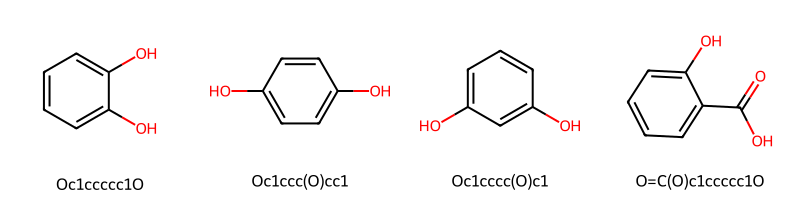

In [72]:
df_filtrado = apl_cutanea[apl_cutanea['Permeability'] == True].copy()


#Dibujar en grilla
mols = df_filtrado['Mol'].tolist()
legends = df_filtrado['SMILES'].tolist()

#Crear y mostrar la imagen
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=legends)
img